In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import socket

host_name = socket.gethostname()

IP_adress = socket.gethostbyname(host_name)

print(f"Host Name : {host_name}")
print(f"Ip Adress : {IP_adress}")

Host Name : fawern
Ip Adress : 192.168.1.107


In [94]:
import numpy as np 
import pandas as pd
from datasets import load_dataset

import matplotlib.pyplot as plt

In [1]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

from pyspark.ml.recommendation import ALS

from pyspark.ml.evaluation import RegressionEvaluator

from itertools import product

In [9]:
try:
    sc = SparkContext.getOrCreate()

    if sc:
        sc.stop()
except Exception as e:
    print(e)

conf = SparkConf().setAppName("Recommendation")
sc = SparkContext(conf=conf).getOrCreate()
spark = SparkSession(sparkContext=sc)

In [10]:
dataset = load_dataset("ashraq/movielens_ratings")  

df_train = dataset['train'].to_pandas().iloc[:, 2:5]
df_val = dataset['validation'].to_pandas().iloc[:, 2:5]

Found cached dataset parquet (C:/Users/90530/.cache/huggingface/datasets/ashraq___parquet/ashraq--movielens_ratings-139b1d983e5c8861/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
df_train.to_csv("../Datas/df_train.csv", index=False)
df_val.to_csv('../Datas/df_val.csv', index=False)

In [12]:
sc

<SparkContext master=local[*] appName=Recommendation>

In [13]:
print(f'App Name : {sc.appName}')
print(f'Version : {sc.version}')
print(f"Spark User : {sc.sparkUser()}")

App Name : Recommendation
Version : 3.4.1
Spark User : 90530


In [14]:
df_rating_train = spark.read.csv("../Datas/df_train.csv", header=True, inferSchema=True)
df_rating_val = spark.read.csv("../Datas/df_val.csv", header=True, inferSchema=True)

concat_data = df_rating_train.union(df_rating_val)

In [15]:
df_rating_train = spark.read.csv("../Datas/df_train.csv", header=True, inferSchema=True)
df_rating_val = spark.read.csv("../Datas/df_val.csv", header=True, inferSchema=True)

# concat_data = df_rating_train.union(df_rating_val).limit(10000)
concat_data = df_rating_train.union(df_rating_val)

In [16]:
num_rows = concat_data.count()
num_uniq_movies = len(concat_data.select("movie_id").distinct().collect())

print(f"Number of concat rows : {num_rows}")
print(f"Number of concat movie : {num_uniq_movies}")

Number of concat rows : 990425
Number of concat movie : 15603


In [17]:
concat_data.printSchema()

root
 |-- movie_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- rating: double (nullable = true)



In [18]:
concat_data.show(10)

+--------+-------+------+
|movie_id|user_id|rating|
+--------+-------+------+
|    2307|  11923|   3.5|
|    7157|  32503|   3.0|
|    1398|  20241|   3.0|
|    2625|  42975|   5.0|
|    8457|  31336|   3.0|
|    2230|  38922|   4.0|
|    5110|  41802|   3.5|
|     935|  36706|   3.5|
|     936|  21320|   5.0|
|    8960|   2930|   2.5|
+--------+-------+------+
only showing top 10 rows



<Axes: >

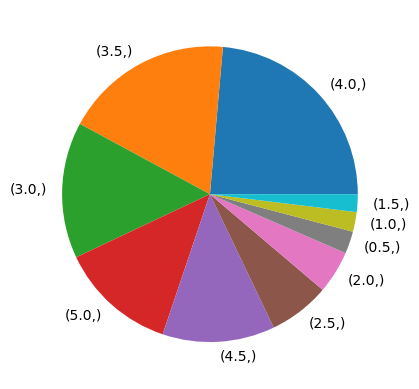

In [19]:
rating_list = [rating[0] for rating in concat_data.select("rating").collect()]
pd.DataFrame(rating_list).value_counts().plot(kind='pie')

Text(0, 0.5, 'Frequency')

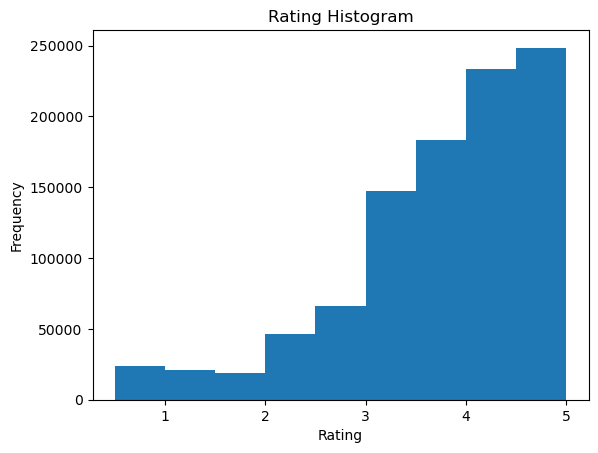

In [101]:
bin_edges = np.arange(0.5, 5.5, step=0.5)

plt.hist(
    rating_list, bins=bin_edges, histtype='bar'
)

plt.title("Rating Histogram")
plt.xlabel('Rating')    
plt.ylabel('Frequency')

In [20]:
indexer_movie = StringIndexer(inputCol='movie_id', outputCol='movie_index')
indexer_user = StringIndexer(inputCol='user_id', outputCol='user_index')    

In [21]:
pipeline = Pipeline(stages=[indexer_movie, indexer_user])

tf_df = pipeline.fit(concat_data).transform(concat_data)

tf_df.show(10)

+--------+-------+------+-----------+----------+
|movie_id|user_id|rating|movie_index|user_index|
+--------+-------+------+-----------+----------+
|    2307|  11923|   3.5|        3.0|    3546.0|
|    7157|  32503|   3.0|     3137.0|     587.0|
|    1398|  20241|   3.0|       20.0|    9092.0|
|    2625|  42975|   5.0|       78.0|    6216.0|
|    8457|  31336|   3.0|      303.0|     716.0|
|    2230|  38922|   4.0|        0.0|    2575.0|
|    5110|  41802|   3.5|       96.0|     362.0|
|     935|  36706|   3.5|       13.0|    1282.0|
|     936|  21320|   5.0|        8.0|   30282.0|
|    8960|   2930|   2.5|      105.0|     562.0|
+--------+-------+------+-----------+----------+
only showing top 10 rows



In [22]:
(train_data, test_data) = tf_df.randomSplit([0.9, 0.1], seed=5030)

print(f"train count : {train_data.count()}")
print(f"test count : {test_data.count()}")

train count : 891651
test count : 98774


In [23]:
?ALS

Init signature:
ALS(
    *,
    rank: int = 10,
    maxIter: int = 10,
    regParam: float = 0.1,
    numUserBlocks: int = 10,
    numItemBlocks: int = 10,
    implicitPrefs: bool = False,
    alpha: float = 1.0,
    userCol: str = 'user',
    itemCol: str = 'item',
    seed: Optional[int] = None,
    ratingCol: str = 'rating',
    nonnegative: bool = False,
    checkpointInterval: int = 10,
    intermediateStorageLevel: str = 'MEMORY_AND_DISK',
    finalStorageLevel: str = 'MEMORY_AND_DISK',
    coldStartStrategy: str = 'nan',
    blockSize: int = 4096,
)
Docstring:     
Alternating Least Squares (ALS) matrix factorization.

ALS attempts to estimate the ratings matrix `R` as the product of
two lower-rank matrices, `X` and `Y`, i.e. `X * Yt = R`. Typically
these approximations are called 'factor' matrices. The general
approach is iterative. During each iteration, one of the factor
matrices is held constant, while the other is solved for using least
squares. The newly-solved factor matr

In [24]:
models = []
df = pd.DataFrame(columns=['rank_', 'iteration', 'regParam_', 'model', 'predictions', 'rmse', 'mse'])

def als_model(rank_, iteration, regParam_):
        als = ALS(
                rank = rank_,
                maxIter = iteration,
                regParam = regParam_, 
                numUserBlocks = 10, # Default
                numItemBlocks = 10, # Default
                implicitPrefs = False, # Default
                alpha = 1.0, # Default
                userCol = 'user_id', # Default
                itemCol = 'movie_id', # Default
                seed = None, # Default
                ratingCol = 'rating', # Default
                nonnegative = False, # Default
                checkpointInterval = 10, # Default
                intermediateStorageLevel = 'MEMORY_AND_DISK', # Default
                finalStorageLevel = 'MEMORY_AND_DISK', # Default
                coldStartStrategy = 'nan', # Default
                blockSize = 4096, # Default
        )

        model = als.fit(train_data)
        model.setPredictionCol("predictions")
        predictions = model.transform(test_data)
        predictions = predictions.filter(predictions.predictions != float('nan'))

        evaluator=RegressionEvaluator(metricName="rmse",labelCol="rating",predictionCol="predictions")
        rmse=evaluator.evaluate(predictions)

        evaluator2=RegressionEvaluator(metricName="mse",labelCol="rating",predictionCol="predictions")
        mse=evaluator2.evaluate(predictions)

        models.append(model)
        df.loc[len(df)] = [rank_, iteration, regParam_, model, predictions, rmse, mse]

In [195]:
rank_params = [10, 50, 200]
iteration_params = [10, 20]
lambda_params = [0.1, 0.01]

for r, i, l in product(rank_params, iteration_params, lambda_params):
    als_model(r, i, l)
    print(f"model {len(df)} is done ")

In [46]:
df.groupby('mse').min().head()

,rank_,iteration,regParam_,model,predictions,rmse
mse,,,,,,
0.690159,10,20,0.1,"ALSModel: uid=ALS_caf31b30a9cf, rank=10","DataFrame[movie_id: int, user_id: int, rating:...",0.830758
0.690764,50,20,0.1,"ALSModel: uid=ALS_7dd9edac96e1, rank=50","DataFrame[movie_id: int, user_id: int, rating:...",0.831122
0.691836,200,20,0.1,"ALSModel: uid=ALS_c0af2dfe74f9, rank=200","DataFrame[movie_id: int, user_id: int, rating:...",0.831767
0.699129,10,10,0.1,"ALSModel: uid=ALS_89896d665241, rank=10","DataFrame[movie_id: int, user_id: int, rating:...",0.836140
0.716072,50,10,0.1,"ALSModel: uid=ALS_77b51b0a74bb, rank=50","DataFrame[movie_id: int, user_id: int, rating:...",0.846210


In [47]:
df.groupby('rmse').min().head()

,rank_,iteration,regParam_,model,predictions,mse
rmse,,,,,,
0.830758,10,20,0.1,"ALSModel: uid=ALS_caf31b30a9cf, rank=10","DataFrame[movie_id: int, user_id: int, rating:...",0.690159
0.831122,50,20,0.1,"ALSModel: uid=ALS_7dd9edac96e1, rank=50","DataFrame[movie_id: int, user_id: int, rating:...",0.690764
0.831767,200,20,0.1,"ALSModel: uid=ALS_c0af2dfe74f9, rank=200","DataFrame[movie_id: int, user_id: int, rating:...",0.691836
0.836140,10,10,0.1,"ALSModel: uid=ALS_89896d665241, rank=10","DataFrame[movie_id: int, user_id: int, rating:...",0.699129
0.846210,50,10,0.1,"ALSModel: uid=ALS_77b51b0a74bb, rank=50","DataFrame[movie_id: int, user_id: int, rating:...",0.716072


In [112]:
model_mse = [m for m in models if m == df.groupby('mse').min().iloc[0]['model']][0] 

model_rmse = [m for m in models if m == df.groupby('rmse').min().iloc[0]['model']][0]


if model_rmse == model_mse:
    model = model_rmse
    print("models are same")
else:
    print("models arenot same")

models are same


In [116]:
df[df['model'] == model]

,rank_,iteration,regParam_,model,predictions,rmse,mse
2,10,20,0.1,"ALSModel: uid=ALS_caf31b30a9cf, rank=10","DataFrame[movie_id: int, user_id: int, rating:...",0.830758,0.690159


In [107]:
predictions = df[df['model'] == model]['predictions'].values[0]
predictions.take(10)

[Row(movie_id=86, user_id=471, rating=5.0, movie_index=67.0, user_index=3530.0, predictions=4.380673885345459),
 Row(movie_id=122, user_id=42834, rating=3.5, movie_index=215.0, user_index=111.0, predictions=2.864773750305176),
 Row(movie_id=158, user_id=30903, rating=2.0, movie_index=587.0, user_index=5130.0, predictions=3.072054624557495),
 Row(movie_id=161, user_id=23364, rating=4.0, movie_index=86.0, user_index=27768.0, predictions=3.9790656566619873),
 Row(movie_id=182, user_id=31983, rating=3.5, movie_index=120.0, user_index=418.0, predictions=3.7553906440734863),
 Row(movie_id=182, user_id=42834, rating=3.0, movie_index=120.0, user_index=111.0, predictions=3.075294017791748),
 Row(movie_id=213, user_id=43527, rating=3.5, movie_index=128.0, user_index=8343.0, predictions=2.6689207553863525),
 Row(movie_id=228, user_id=148, rating=4.0, movie_index=262.0, user_index=140.0, predictions=3.4358553886413574),
 Row(movie_id=231, user_id=148, rating=3.0, movie_index=108.0, user_index=140.

In [49]:
from pyspark.sql.functions import col
test = model.recommendForAllUsers(10).filter(col('user_id')== 3).select("recommendations").collect()
for item in test[0][0]:
    print(item.rating)

6.248376846313477
6.206021785736084
6.082241058349609
5.799007415771484
5.753098487854004
5.7023186683654785
5.5785064697265625
5.552544116973877
5.527855396270752
5.525574684143066


In [ ]:
# 5 movies recommendation for user_id = 100
user_recs = model.recommendForAllUsers(numItems=5)
movie_recommendation = user_recs.where(user_recs.user_id == 100).select("recommendations.movie_id", "recommendations.rating").collect()

In [184]:
movie_df = pd.DataFrame(columns=["userId", 'movieId', 'movieRating'])

movie_id = movie_recommendation[0][0]
movie_rating = movie_recommendation[0][1]

for id_, rating in zip(movie_id, movie_rating):
    movie_df.loc[len(movie_df)] = [5, id_, rating]

movie_df

,userId,movieId,movieRating
0,5.0,14418.0,5.157757
1,5.0,9835.0,5.096902
2,5.0,1362.0,5.094255
3,5.0,12472.0,4.858741
4,5.0,14382.0,4.765639


In [ ]:
item_recs = model.recommendForAllItems(numUsers=5)
user_recommendation = item_recs.where(item_recs.movie_id == 100).select("recommendations.user_id", "recommendations.rating").collect()

In [188]:
user_df = pd.DataFrame(columns=['movieId', 'userId', 'movieRating'])

user_id = user_recommendation[0][0]
movie_rating = user_recommendation[0][1]

for id_, rating in zip(user_id, movie_rating):
    user_df.loc[len(user_df)] = [100, id_, rating]

user_df

,movieId,userId,movieRating
0,100.0,23856.0,6.120047
1,100.0,27834.0,6.074754
2,100.0,6238.0,5.904249
3,100.0,28312.0,5.868137
4,100.0,13173.0,5.789801
